In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Traditional ML
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow Version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import pandas as pd
import numpy as np

def load_and_explore_data(filepath):
    """Load gold stock data and perform initial exploration"""
    # Load data
    try:
        df = pd.read_csv(filepath)
    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
        print("Please upload your 'goldstock_v2.csv' file or provide the correct path.")
        print("Loading a placeholder dataset for demonstration.")

        try:
            # Example using a dummy dataset structure for demonstration
            data = {'Date': pd.date_range(start='2020-01-01', periods=100, freq='D'),
                    'Open': np.random.rand(100)*1000 + 1500,
                    'High': np.random.rand(100)*1000 + 1600,
                    'Low': np.random.rand(100)*1000 + 1400,
                    'Close': np.random.rand(100)*1000 + 1500,
                    'Volume': np.random.rand(100)*1000000}
            df = pd.DataFrame(data)
        except Exception as e:
            print(f"Could not load placeholder data: {e}")
            return None

    # Drop unnecessary columns
    if 'Unnamed: 0' in df.columns:
        df = df.drop('Unnamed: 0', axis=1)

    # Rename 'Close/Last' to 'Close' for easier access
    if 'Close/Last' in df.columns:
        df = df.rename(columns={'Close/Last': 'Close'})

    # Convert Date to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)

    print("="*80)
    print("DATASET OVERVIEW")
    print("="*80)
    print(f"\nShape: {df.shape}")
    print(f"\nDate Range: {df['Date'].min()} to {df['Date'].max()}")
    print(f"Total Days: {len(df)}")
    print(f"\nMissing Values:\n{df.isnull().sum()}")
    print(f"\nBasic Statistics:\n{df.describe()}")

    # Check for data quality issues
    print("\n" + "="*80)
    print("DATA QUALITY CHECKS")
    print("="*80)

    # Check for duplicates
    duplicates = df.duplicated(subset=['Date']).sum()
    print(f"Duplicate dates: {duplicates}")

    # Check for zeros in volume
    zero_volume = (df['Volume'] == 0).sum()
    print(f"Days with zero volume: {zero_volume}")

    return df

# Load your data with the correct filepath
df = load_and_explore_data('/kaggle/input/gold-stock-prices/goldstock v2.csv')

# Check if df is loaded successfully before proceeding
if df is not None:
    print("\n" + "="*80)
    print("DATA LOADED SUCCESSFULLY")
    print("="*80)
    print(f"Columns: {list(df.columns)}")
    print(f"\nFirst few rows:\n{df.head()}")
else:
    print("Data loading failed. Please check the file path and format.")

Error: File not found at /kaggle/input/gold-stock-prices/goldstock v2.csv
Please upload your 'goldstock_v2.csv' file or provide the correct path.
Loading a placeholder dataset for demonstration.
DATASET OVERVIEW

Shape: (100, 6)

Date Range: 2020-01-01 00:00:00 to 2020-04-09 00:00:00
Total Days: 100

Missing Values:
Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Basic Statistics:
                      Date         Open         High          Low  \
count                  100   100.000000   100.000000   100.000000   
mean   2020-02-19 12:00:00  1994.942314  2131.654817  1880.209528   
min    2020-01-01 00:00:00  1521.823397  1612.607520  1405.505799   
25%    2020-01-25 18:00:00  1748.904350  1897.778823  1638.990995   
50%    2020-02-19 12:00:00  1992.691851  2143.720988  1896.966564   
75%    2020-03-15 06:00:00  2262.551816  2389.650845  2140.726390   
max    2020-04-09 00:00:00  2484.989656  2584.110319  2395.437516   
std                    NaN

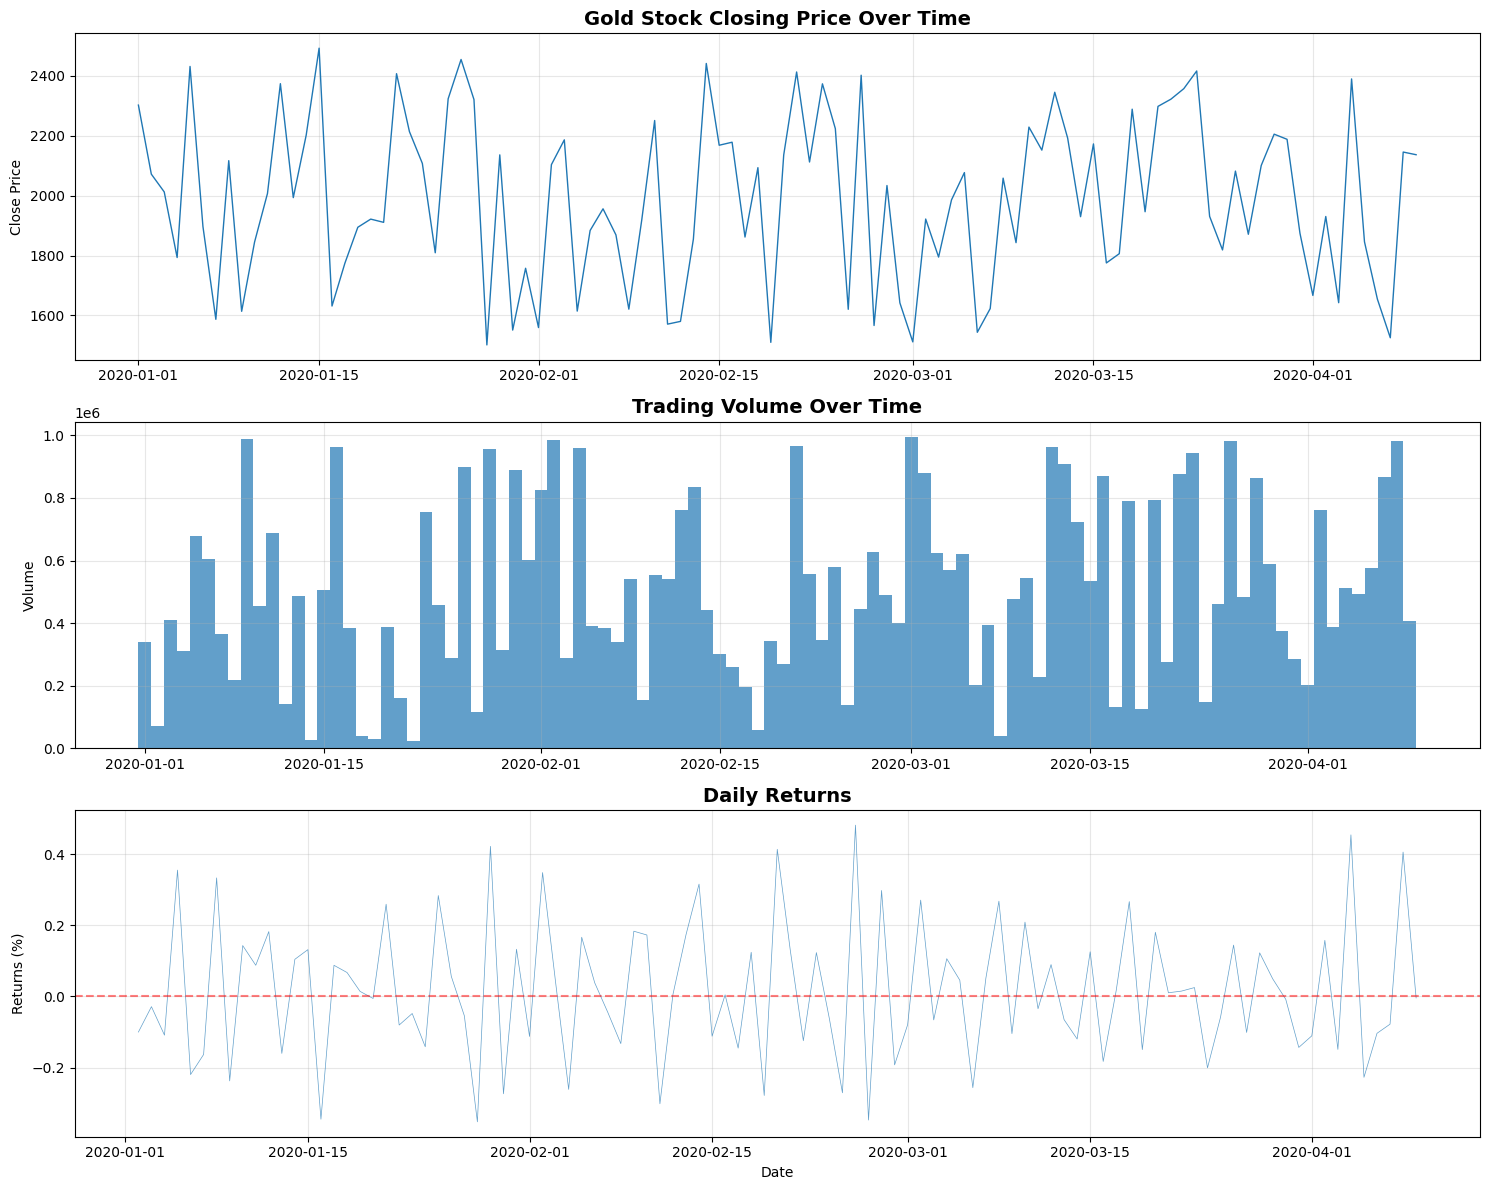

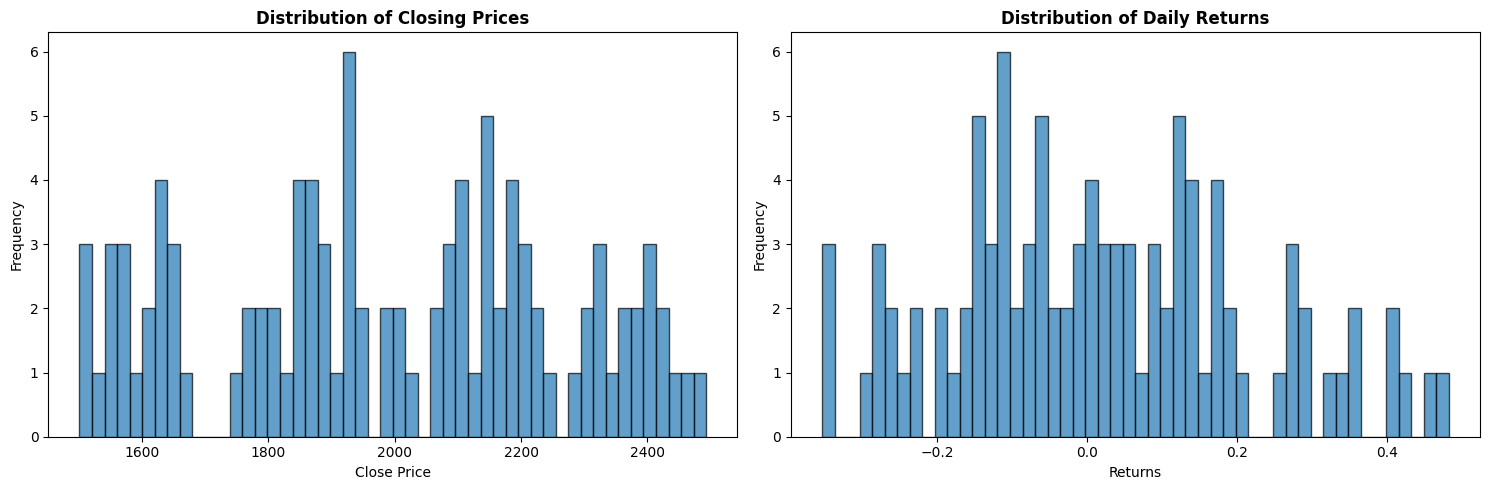

In [ ]:
def plot_price_trends(df):
    """Visualize price trends and patterns"""

    fig, axes = plt.subplots(3, 1, figsize=(15, 12))

    # Close price over time
    axes[0].plot(df['Date'], df['Close'], linewidth=1)
    axes[0].set_title('Gold Stock Closing Price Over Time', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Close Price')
    axes[0].grid(True, alpha=0.3)

    # Volume over time
    axes[1].bar(df['Date'], df['Volume'], width=1, alpha=0.7)
    axes[1].set_title('Trading Volume Over Time', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Volume')
    axes[1].grid(True, alpha=0.3)

    # Daily returns
    df['Returns'] = df['Close'].pct_change()
    axes[2].plot(df['Date'], df['Returns'], linewidth=0.5, alpha=0.7)
    axes[2].set_title('Daily Returns', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Date')
    axes[2].set_ylabel('Returns (%)')
    axes[2].axhline(y=0, color='r', linestyle='--', alpha=0.5)
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Distribution analysis
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Price distribution
    axes[0].hist(df['Close'], bins=50, edgecolor='black', alpha=0.7)
    axes[0].set_title('Distribution of Closing Prices', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Close Price')
    axes[0].set_ylabel('Frequency')

    # Returns distribution
    axes[1].hist(df['Returns'].dropna(), bins=50, edgecolor='black', alpha=0.7)
    axes[1].set_title('Distribution of Daily Returns', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Returns')
    axes[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

plot_price_trends(df)


In [ ]:
def create_technical_indicators(df):
    """Create technical indicators for stock prediction"""

    df = df.copy()

    # Simple Moving Averages
    df['SMA_5'] = df['Close'].rolling(window=5).mean()
    df['SMA_10'] = df['Close'].rolling(window=10).mean()
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()

    # Exponential Moving Averages
    df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()

    # MACD
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # RSI (Relative Strength Index)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Bollinger Bands
    df['BB_Middle'] = df['Close'].rolling(window=20).mean()
    bb_std = df['Close'].rolling(window=20).std()
    df['BB_Upper'] = df['BB_Middle'] + (bb_std * 2)
    df['BB_Lower'] = df['BB_Middle'] - (bb_std * 2)
    df['BB_Width'] = df['BB_Upper'] - df['BB_Lower']

    # Volatility
    df['Volatility'] = df['Close'].rolling(window=10).std()

    # Price momentum
    df['Momentum'] = df['Close'] - df['Close'].shift(4)

    # Volume features
    df['Volume_SMA_5'] = df['Volume'].rolling(window=5).mean()
    df['Volume_Ratio'] = df['Volume'] / df['Volume_SMA_5']

    # Lag features (previous days' prices)
    for i in range(1, 6):
        df[f'Close_Lag_{i}'] = df['Close'].shift(i)

    # Price range features
    df['High_Low_Pct'] = (df['High'] - df['Low']) / df['Low']
    df['Close_Open_Pct'] = (df['Close'] - df['Open']) / df['Open']

    # Time-based features
    df['Day_of_Week'] = df['Date'].dt.dayofweek
    df['Month'] = df['Date'].dt.month
    df['Quarter'] = df['Date'].dt.quarter
    df['Day_of_Year'] = df['Date'].dt.dayofyear

    # Target: Next day's closing price
    df['Target'] = df['Close'].shift(-1)

    # Drop rows with NaN values
    df = df.dropna().reset_index(drop=True)

    print(f"\nFeatures created. New shape: {df.shape}")
    print(f"Feature columns: {df.columns.tolist()}")

    return df

df_features = create_technical_indicators(df)


Features created. New shape: (50, 36)
Feature columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Returns', 'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'BB_Width', 'Volatility', 'Momentum', 'Volume_SMA_5', 'Volume_Ratio', 'Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3', 'Close_Lag_4', 'Close_Lag_5', 'High_Low_Pct', 'Close_Open_Pct', 'Day_of_Week', 'Month', 'Quarter', 'Day_of_Year', 'Target']


In [ ]:
def prepare_train_test_data(df, test_size=0.2):
    """Prepare data for training and testing"""

    # Define feature columns (exclude Date, Target, and Returns)
    feature_cols = [col for col in df.columns if col not in ['Date', 'Target', 'Returns', 'Close']]

    X = df[feature_cols].values
    y = df['Target'].values
    dates = df['Date'].values

    # Time series split (no shuffling)
    split_idx = int(len(X) * (1 - test_size))

    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    dates_train, dates_test = dates[:split_idx], dates[split_idx:]

    print(f"\nTraining set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Scale target (important for neural networks)
    target_scaler = StandardScaler()
    y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1)).flatten()

    return {
        'X_train': X_train_scaled,
        'X_test': X_test_scaled,
        'y_train': y_train_scaled,
        'y_test': y_test_scaled,
        'y_train_original': y_train,
        'y_test_original': y_test,
        'dates_train': dates_train,
        'dates_test': dates_test,
        'feature_cols': feature_cols,
        'scaler': scaler,
        'target_scaler': target_scaler
    }

data = prepare_train_test_data(df_features)


Training set: 40 samples
Test set: 10 samples


In [ ]:
def train_traditional_models(data):
    """Train and evaluate traditional ML models"""

    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42),
        'SVR': SVR(kernel='rbf', C=100, gamma='scale')
    }

    results = {}

    for name, model in models.items():
        print(f"\nTraining {name}...")

        # Train
        model.fit(data['X_train'], data['y_train'])

        # Predict
        y_pred_train = model.predict(data['X_train'])
        y_pred_test = model.predict(data['X_test'])

        # Inverse transform predictions
        y_pred_train_original = data['target_scaler'].inverse_transform(
            y_pred_train.reshape(-1, 1)
        ).flatten()
        y_pred_test_original = data['target_scaler'].inverse_transform(
            y_pred_test.reshape(-1, 1)
        ).flatten()

        # Calculate metrics
        train_rmse = np.sqrt(mean_squared_error(data['y_train_original'], y_pred_train_original))
        test_rmse = np.sqrt(mean_squared_error(data['y_test_original'], y_pred_test_original))
        train_mae = mean_absolute_error(data['y_train_original'], y_pred_train_original)
        test_mae = mean_absolute_error(data['y_test_original'], y_pred_test_original)
        train_r2 = r2_score(data['y_train_original'], y_pred_train_original)
        test_r2 = r2_score(data['y_test_original'], y_pred_test_original)

        results[name] = {
            'model': model,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_mae': train_mae,
            'test_mae': test_mae,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'predictions_test': y_pred_test_original
        }

        print(f"  Train RMSE: {train_rmse:.2f}, Test RMSE: {test_rmse:.2f}")
        print(f"  Train MAE: {train_mae:.2f}, Test MAE: {test_mae:.2f}")
        print(f"  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")

    return results

ml_results = train_traditional_models(data)



Training Linear Regression...
  Train RMSE: 130.48, Test RMSE: 856.43
  Train MAE: 111.02, Test MAE: 565.93
  Train R²: 0.7503, Test R²: -9.8031

Training Ridge Regression...
  Train RMSE: 148.16, Test RMSE: 494.05
  Train MAE: 128.34, Test MAE: 443.38
  Train R²: 0.6780, Test R²: -2.5951

Training Random Forest...
  Train RMSE: 92.70, Test RMSE: 382.40
  Train MAE: 74.87, Test MAE: 350.44
  Train R²: 0.8739, Test R²: -1.1537

Training Gradient Boosting...
  Train RMSE: 0.01, Test RMSE: 392.67
  Train MAE: 0.01, Test MAE: 348.77
  Train R²: 1.0000, Test R²: -1.2709

Training SVR...
  Train RMSE: 25.18, Test RMSE: 335.29
  Train MAE: 24.58, Test MAE: 304.43
  Train R²: 0.9907, Test R²: -0.6557


In [ ]:
def create_dnn_model(input_dim):
    """Create Dense Neural Network using Sequential API"""

    model = Sequential([
        layers.Dense(128, activation='relu', input_dim=input_dim),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    return model

def create_lstm_sequence_data(X, y, sequence_length=10):
    """Create sequences for LSTM"""

    X_seq, y_seq = [], []

    for i in range(len(X) - sequence_length):
        X_seq.append(X[i:i+sequence_length])
        y_seq.append(y[i+sequence_length])

    return np.array(X_seq), np.array(y_seq)

def create_lstm_model(sequence_length, n_features):
    """Create LSTM model using Sequential API"""

    model = Sequential([
        layers.LSTM(64, return_sequences=True, input_shape=(sequence_length, n_features)),
        layers.Dropout(0.2),
        layers.LSTM(32, return_sequences=False),
        layers.Dropout(0.2),
        layers.Dense(16, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    return model

# Train DNN
print("\n" + "="*80)
print("TRAINING DEEP NEURAL NETWORK")
print("="*80)

dnn_model = create_dnn_model(data['X_train'].shape[1])

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

history_dnn = dnn_model.fit(
    data['X_train'], data['y_train'],
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=0
)

print(f"Training completed in {len(history_dnn.history['loss'])} epochs")


TRAINING DEEP NEURAL NETWORK
Training completed in 32 epochs


In [ ]:
def create_multi_input_model(input_dim):
    """Create multi-input model using Functional API"""

    # Price features
    price_input = layers.Input(shape=(input_dim,), name='price_input')

    # Branch 1: Technical indicators
    x1 = layers.Dense(64, activation='relu')(price_input)
    x1 = layers.Dropout(0.2)(x1)
    x1 = layers.Dense(32, activation='relu')(x1)

    # Branch 2: Volume and momentum
    x2 = layers.Dense(32, activation='relu')(price_input)
    x2 = layers.Dropout(0.2)(x2)

    # Concatenate branches
    combined = layers.concatenate([x1, x2])

    # Final layers
    x = layers.Dense(64, activation='relu')(combined)
    x = layers.Dropout(0.2)(x)
    output = layers.Dense(1)(x)

    model = Model(inputs=price_input, outputs=output)

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    return model

# Train Functional API model
print("\n" + "="*80)
print("TRAINING FUNCTIONAL API MODEL")
print("="*80)

functional_model = create_multi_input_model(data['X_train'].shape[1])

history_functional = functional_model.fit(
    data['X_train'], data['y_train'],
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=0
)

print(f"Training completed in {len(history_functional.history['loss'])} epochs")


TRAINING FUNCTIONAL API MODEL
Training completed in 60 epochs


In [ ]:
def evaluate_dl_model(model, data, model_name):
    """Evaluate deep learning model"""

    # Predictions
    y_pred_train = model.predict(data['X_train'], verbose=0).flatten()
    y_pred_test = model.predict(data['X_test'], verbose=0).flatten()

    # Inverse transform
    y_pred_train_original = data['target_scaler'].inverse_transform(
        y_pred_train.reshape(-1, 1)
    ).flatten()
    y_pred_test_original = data['target_scaler'].inverse_transform(
        y_pred_test.reshape(-1, 1)
    ).flatten()

    # Metrics
    train_rmse = np.sqrt(mean_squared_error(data['y_train_original'], y_pred_train_original))
    test_rmse = np.sqrt(mean_squared_error(data['y_test_original'], y_pred_test_original))
    train_mae = mean_absolute_error(data['y_train_original'], y_pred_train_original)
    test_mae = mean_absolute_error(data['y_test_original'], y_pred_test_original)
    train_r2 = r2_score(data['y_train_original'], y_pred_train_original)
    test_r2 = r2_score(data['y_test_original'], y_pred_test_original)

    print(f"\n{model_name} Results:")
    print(f"  Train RMSE: {train_rmse:.2f}, Test RMSE: {test_rmse:.2f}")
    print(f"  Train MAE: {train_mae:.2f}, Test MAE: {test_mae:.2f}")
    print(f"  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")

    return {
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'predictions_test': y_pred_test_original
    }

dl_results = {
    'DNN (Sequential)': evaluate_dl_model(dnn_model, data, 'DNN (Sequential)'),
    'Multi-Input (Functional)': evaluate_dl_model(functional_model, data, 'Multi-Input (Functional)')
}



DNN (Sequential) Results:
  Train RMSE: 176.80, Test RMSE: 322.58
  Train MAE: 143.70, Test MAE: 305.28
  Train R²: 0.5415, Test R²: -0.5326

Multi-Input (Functional) Results:
  Train RMSE: 112.19, Test RMSE: 359.80
  Train MAE: 88.35, Test MAE: 337.11
  Train R²: 0.8154, Test R²: -0.9067



MODEL COMPARISON
                   Model  Test RMSE   Test MAE   Test R²
       Linear Regression 856.433898 565.925456 -9.803056
        Ridge Regression 494.054353 443.383620 -2.595079
           Random Forest 382.398351 350.436272 -1.153729
       Gradient Boosting 392.666247 348.765925 -1.270942
                     SVR 335.286498 304.429813 -0.655736
        DNN (Sequential) 322.575966 305.280733 -0.532579
Multi-Input (Functional) 359.799697 337.106600 -0.906692


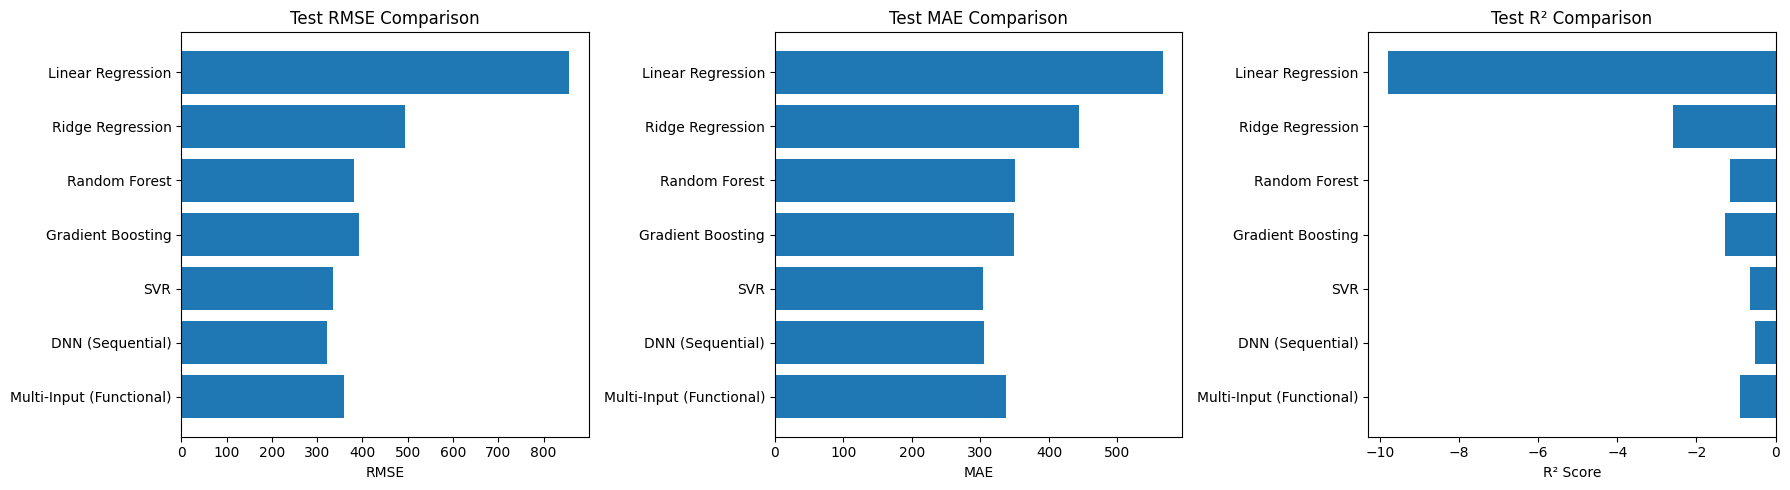

In [ ]:
# Combine all results
all_results = {**ml_results, **dl_results}

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(all_results.keys()),
    'Test RMSE': [all_results[m]['test_rmse'] for m in all_results],
    'Test MAE': [all_results[m]['test_mae'] for m in all_results],
    'Test R²': [all_results[m]['test_r2'] for m in all_results]
})

print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].barh(comparison_df['Model'], comparison_df['Test RMSE'])
axes[0].set_xlabel('RMSE')
axes[0].set_title('Test RMSE Comparison')
axes[0].invert_yaxis()

axes[1].barh(comparison_df['Model'], comparison_df['Test MAE'])
axes[1].set_xlabel('MAE')
axes[1].set_title('Test MAE Comparison')
axes[1].invert_yaxis()

axes[2].barh(comparison_df['Model'], comparison_df['Test R²'])
axes[2].set_xlabel('R² Score')
axes[2].set_title('Test R² Comparison')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

